## Import Modules

In [4]:
import pandas as pd
import numpy as np 
from gensim import models
from lib import weat
import os
import scipy
import matplotlib.pyplot as plt
import importlib
from scipy import stats
import seaborn as sns
import fasttext
import fasttext.util
import glob

## Load Glove Model

In [17]:
# import and load glove model
def loadGloveModel(file):
    print("Loading glove model...")
    f = open(file,'r', encoding='utf-8')
    gloveModel = {}
    for line in f:
        splitLines = line.split(' ')
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

In [18]:
# load Glove model
glove = loadGloveModel('data/glove.840B.300d.txt')

Loading glove model...
2196017  words loaded!


## Load fastText model

In [5]:
def load_fasttext(model): 
    
    model_path = 'data/' + model
    ft = fasttext.load_model(model_path)
    return ft

In [6]:
fasttext.load_model('data/cc.ht.300.bin')

In [7]:
ft = load_fasttext('cc.ht.300.bin')

In [248]:
def normal_test(distr):
    k2, p = stats.normaltest(distr)
    alpha = 1e-3
    if p < alpha: 
        return 'Yes'
    else: return 'No'

In [11]:
def get_tar_att_arrays(model, t1, a1, a2, algorithm, t2=None,):
    if algorithm == 'weat':
        tar1 = np.array([model[vector] for vector in t1])
        tar2 = np.array([model[vector] for vector in t2])
        att1 = np.array([model[vector] for vector in a1])
        att2 = np.array([model[vector] for vector in a2])
        
        return tar1, tar2, att1, att2
    
    elif algorithm == 'wefat':
        tar1 = np.array([model[vector] for vector in t1])
        att1 = np.array([model[vector] for vector in a1])
        att2 = np.array([model[vector] for vector in a2])
        
        return tar1, att1, att2

def get_matrices(filepath, model, algorithm):
    data_file = pd.read_csv(filepath, sep=',\s*', engine='python',  header=None, index_col=0)
    
    if algorithm == 'weat':
        # get targets and attribute labels
        target_names = list(data_file.index)[:2]
        attribute_names = list(data_file.index)[2:]

        # get targets and attribute sets
        targets = data_file.loc[target_names]
        attributes = data_file.loc[attribute_names]

        # get arrays, one for each set of target and attribute
        tar1 = targets.loc[target_names[0]]
        tar2 = targets.loc[target_names[1]]
        att1 = attributes.loc[attribute_names[0]]
        att2 = attributes.loc[attribute_names[1]]

        # remove any NaN values that have been read due to mismatch of columns 
        tar1 = tar1[~pd.isna(tar1)]
        tar2 = tar2[~pd.isna(tar2)]
        att1 = att1[~pd.isna(att1)]
        att2 = att2[~pd.isna(att2)]

        # give numpy array of glove word embeddings for targets and attributes
        tar1, tar2, att1, att2 = get_tar_att_arrays(model, tar1, att1, att2, algorithm, t2 = tar2, )

        return target_names, attribute_names, tar1, tar2, att1, att2
    
    elif algorithm == 'wefat':
        # get targets and attribute labels
        target_names = list(data_file.index)[:1]
        attribute_names = list(data_file.index)[1:]

        # get targets and attribute sets
        targets = data_file.loc[target_names]
        attributes = data_file.loc[attribute_names]

        # get arrays, one for each set of target and attribute
        tar1 = targets.loc[target_names[0]]
        att1 = attributes.loc[attribute_names[0]]
        att2 = attributes.loc[attribute_names[1]]

        # remove any NaN values that have been read due to mismatch of columns 
        tar1 = tar1[~pd.isna(tar1)]
        att1 = att1[~pd.isna(att1)]
        att2 = att2[~pd.isna(att2)]
        
        # give numpy array of glove word embeddings for targets and attributes
        tar1, att1, att2 = get_tar_att_arrays(model, tar1, att1, att2, algorithm)

        return target_names, attribute_names, tar1, att1, att2

def output_values(filepath, model, algorithm): 
    # algorithm selection
    if algorithm == 'weat':     
        alg_object = weat.Weat()
        
        # retrieve target names and attributes to form the table
        target_names, attribute_names, _, _, _, _ = get_matrices(filepath, model, algorithm)
        # retrive the word embeddings for the targets and attributes
        _, _, t1, t2, a1, a2 = get_matrices(filepath, model, algorithm)
        # calculate the effect size 
        effect_size = alg_object.effect_size(t1, t2, a1, a2)
        # calculate the p-value, test statistic, and permutations
        p_val, test_stat, distr = alg_object.p_value(t1, t2, a1, a2)
        
        
    elif algorithm =='wefat':
        alg_object = weat.Wefat()
        
        # retrieve target names and attributes to form the table
        target_names, attribute_names, _, _, _ = get_matrices(filepath, model, algorithm)
        # retrive the word embeddings for the targets and attributes
        _, _, targets, a1, a2 = get_matrices(filepath, model, algorithm)
        
        effect_size, p_val = list(), list()
        for target in targets:
            # calculate the effect size 
            eff_size = alg_object.effect_size(target, a1, a2)
            effect_size.append(eff_size)
            
            # calculate the p-value, test statistic, and permutations
            p_value, test_stat, distr = alg_object.p_value(target, a1, a2)
            p_val.append(p_value)

    
    return target_names, attribute_names, effect_size, p_val

def output_table(model, algorithm, directory=None, filepath=None):
    print('Reading files...\n')
    
    # if a directory is given to run the test on all files
    if directory: 
        targets, attributes, effect_size, p_value = dict(), dict(), dict(), dict()
        # loop over all files in the directory
        for index, filename in enumerate(os.listdir(directory)):
            if not filename.startswith('.'):  # ignore hidden files
                filepath = directory + filename
                print (filepath)
                targets[index], attributes[index], effect_size[index], p_value[index] = \
                                            output_values(filepath, model, algorithm)
        # create a dataframe with the targets, attributes, and effect size
        output_df = pd.DataFrame(data = list(zip(targets.values(), attributes.values(), effect_size.values(), p_value.values())),
                             columns = ['Targets', 'Attributes', 'Effect Size', 'P-Value'])
#         output_df['Effect Size'] = output_df['Effect Size'].round(decimals=2)
                
    # if a specific filepath is given to the run a test only on that file          
    elif filepath: 
        _, _, e_s, p_value = output_values(filepath, model, algorithm)
        
        if algorithm == 'wefat':
            # get the targets from the first row of the file
            target = pd.read_csv(filepath, nrows=1, header=None).dropna(axis=1).values.flatten().tolist()
#             if target.isin('Haitian Creole word'): 
#                 target.remove('Haitian Creole word')
            # strip whitespaces around the target names
            target = list(map(str.strip, target))
            output_df = pd.DataFrame(data = list(zip(target, e_s, p_value)), columns = ['Target', 'Effect Size', 'P-Value'])
        
        elif algorithm =='weat':
            output_df = pd.DataFrame(data = {'Effect Size': e_s, 'P-Value': p_value}, index=[0])
            
        output_df['Effect Size'] = output_df['Effect Size'].round(decimals=2)

    print('Finished.')
    return output_df

In [45]:
os.chdir('/Users/adimaini/Documents/GW/Research/CODE.nosync/WEAT-WEFAT/')

In [98]:
def corpus_bins(): 
    '''Runs the OpenSubtitle 2018 corpus bins for the gender weat tests'''
    
    bins = [f for f in os.listdir('data/OpenTitle') if f.endswith('.bin')]

    df = pd.DataFrame()
    for corpus in bins: 
        test_df = output_table(model = load_fasttext('/OpenTitle/' + corpus), 
                       algorithm = 'weat', 
                       directory = 'targets_attributes_data/gender weat/')
        test_df['corpus'] = corpus
        df = pd.concat([df, test_df], axis=0)
    
    df.corpus = df.corpus.replace('001pct_embeddings-003.bin', 0.001)
    df.corpus = df.corpus.replace('01pct_embeddings-006.bin', 0.01)
    df.corpus = df.corpus.replace('1pct_embeddings-002.bin', 1)
    df.corpus = df.corpus.replace('10pct_embeddings-005.bin', 10)
    df.corpus = df.corpus.replace('50pct_embeddings-004.bin', 50)
    return df

In [73]:
def gender_hat(): 
    '''Runs the gender weat tests using fasttext haitian creole word embeddings'''
    gender_dir = 'targets_attributes_data/haitian-creole/gender weat/'
    df = output_table(model = load_fasttext('cc.ht.300.bin'),
                      algorithm = 'weat', 
                      directory = gender_dir)
    return df

### run the good/bad words testing for what is considered good and bad with pre-trained word embeddings

In [14]:
df_good_bad = output_table(model=ft,
                                filepath = '/Users/adimaini/Documents/GW/Research/CODE.nosync/WEAT-WEFAT/targets_attributes_data/haitian-creole/wefat sanitation disease etc.csv',
                                algorithm = 'wefat')

Reading files...

Finished.


In [27]:
df_good_bad_cp = df_good_bad.copy()

In [30]:
english_words = ['sanitation', 'clean',  'toilet', 'hands', 'water', 'hygiene', 'covid', 'vaccine',  
                 'water', 'cholera', 'diarrhea', 'fever', 'typhoid', 'garbage', 'osmosis', 'filter', 
                 'bottled', 'wells', 'fresh', 'pump', 'springs', 'latrine', 'DINEPA', 'CAEPA', 'maintenance', 
                 'treatment', 'fecal', 'sludge', 'dirty', 'malaria', 'feces']
df_good_bad_cp['English Words'] = english_words
df_good_bad_cp.rename(columns={'Target': 'Haitian Word'}, inplace=True)
new_order = ['English Words', 'Haitian Word', 'Effect Size', 'P-Value']
df_good_bad_cp[new_order].to_csv('data/good_bad_weat.csv')

In [97]:
df = gender_hat()

Reading files...

targets_attributes_data/haitian-creole/gender weat/science vs arts.csv
targets_attributes_data/haitian-creole/gender weat/math vs arts.csv
Finished.


In [99]:
df

,Targets,Attributes,Effect Size,P-Value
0,"[Science, Arts]","[Male terms, Female terms]",-0.680677,0.917522
1,"[Math, Arts]","[Male terms, Female terms]",-0.602545,0.884332


In [71]:
df = corpus_bins()

Reading files...

targets_attributes_data/gender weat/male vs female names.csv
targets_attributes_data/gender weat/science vs arts.csv
targets_attributes_data/gender weat/math vs arts.csv
Finished.
Reading files...

targets_attributes_data/gender weat/male vs female names.csv
targets_attributes_data/gender weat/science vs arts.csv
targets_attributes_data/gender weat/math vs arts.csv
Finished.
Reading files...

targets_attributes_data/gender weat/male vs female names.csv
targets_attributes_data/gender weat/science vs arts.csv
targets_attributes_data/gender weat/math vs arts.csv
Finished.
Reading files...

targets_attributes_data/gender weat/male vs female names.csv
targets_attributes_data/gender weat/science vs arts.csv
targets_attributes_data/gender weat/math vs arts.csv
Finished.
Reading files...

targets_attributes_data/gender weat/male vs female names.csv
targets_attributes_data/gender weat/science vs arts.csv
targets_attributes_data/gender weat/math vs arts.csv
Finished.


### reading in the opensubtitles gender tests that were conducted

In [92]:
df = pd.read_csv('data/OpenSubtitles_gender_tests.csv', index_col=False)

In [94]:
df.corpus = df.corpus.replace('001pct_embeddings-003.bin', 0.001)
df.corpus = df.corpus.replace('01pct_embeddings-006.bin', 0.01)
df.corpus = df.corpus.replace('1pct_embeddings-002.bin', 1)
df.corpus = df.corpus.replace('10pct_embeddings-005.bin', 10)
df.corpus = df.corpus.replace('50pct_embeddings-004.bin', 50)
df.drop(columns='Unnamed: 0', inplace=True)

In [96]:
df.sort_values(by=['Targets', 'corpus'])

,Targets,Attributes,Effect Size,P-Value,corpus
9,"['Male names', 'Female names']","['Career', 'Family']",-0.115712,0.588382,0.001
12,"['Male names', 'Female names']","['Career', 'Family']",0.582209,0.126697,0.010
3,"['Male names', 'Female names']","['Career', 'Family']",1.521258,0.001008,1.000
0,"['Male names', 'Female names']","['Career', 'Family']",1.358275,0.003356,10.000
6,"['Male names', 'Female names']","['Career', 'Family']",1.540280,0.000930,50.000
11,"['Math', 'Arts']","['Male terms', 'Female terms']",-0.560788,0.870804,0.001
14,"['Math', 'Arts']","['Male terms', 'Female terms']",-0.440599,0.811011,0.010
5,"['Math', 'Arts']","['Male terms', 'Female terms']",-0.125233,0.599607,1.000
2,"['Math', 'Arts']","['Male terms', 'Female terms']",1.109598,0.013622,10.000
8,"['Math', 'Arts']","['Male terms', 'Female terms']",1.214212,0.008197,50.000


In [6]:
# haitian-creole weat test - flowers vs insects
df_haitian = output_table(model=ft, directory='targets_attributes_data/haitian-creole/', algorithm='weat')

NameError: name 'ft' is not defined

In [145]:
df_haitian_wefat = output_table(model=ft,
                                filepath = '/Users/adimaini/Documents/GW/Research/CODE/WEAT-WEFAT/targets_attributes_data/haitian-creole/sanitation disease wefat.csv',
                                algorithm = 'wefat')

Reading files...

Finished.


In [146]:
df_haitian_wefat

,Target,Effect Size,P-Value
0,sanitasyon,0.08,0.395601
1,ijyèn,-0.04,0.557786
2,flòch,0.35,0.110377
3,pwòp,0.27,0.171211
4,filtre,-0.23,0.788114
5,savon,-0.04,0.559481
6,lave,0.00,0.495642
7,maladi,-0.19,0.747552
8,dyare,-0.35,0.889312
9,kolera,-0.18,0.737959


## ANEW Dataset import

In [31]:
anew = pd.read_csv('/Users/adimaini/Documents/GW/Research/CODE.nosync/WEAT-WEFAT/data/Bellezza_Lexicon.csv',
                   usecols=['word', 'Haitian Creole word', 'combined_pleasantness'])

In [32]:
anew.sort_values(by='Haitian Creole word')

,word,Haitian Creole word,combined_pleasantness
8,ambition,Anbisyon,4.28
203,luscious,Apetisan,4.23
39,bunny,Bunny,4.33
110,errand,Komisyon,3.12
33,book,Liv,3.69
...,...,...,...
389,weapon,zam,2.08
129,friend,zanmi,4.53
25,bird,zwazo,4.03
249,pillow,zòrye,4.15


In [29]:

anew[anew.duplicated(subset='Haitian Creole word', keep='first')].count()

word                     19
Haitian Creole word      19
combined_pleasantness    19
dtype: int64

In [25]:
# find the duplicate words 
anew[anew.duplicated(subset='Haitian Creole word', keep=False)]\
        .sort_values(by='Haitian Creole word')

,word,Haitian Creole word,combined_pleasantness
1,accident,aksidan,1.51
69,crash,aksidan,1.56
15,assassin,asasen,1.56
185,killer,asasen,1.25
259,pretty,bèl,4.40
74,cute,bèl,4.37
150,handsome,bèl,4.37
49,chair,chèz,3.26
302,seat,chèz,3.20
366,unfaithful,enfidèl,1.54


In [21]:
anew.loc[:, ['word', 'Haitian Creole word']].columns 

Index(['word', 'Haitian Creole word'], dtype='object')

In [27]:
# group the alike words together and average their scores
anew_g = anew.groupby(by='Haitian Creole word', axis=0).mean().reset_index()

In [34]:
anew_g.sort_values(by='Haitian Creole word')['Haitian Creole word']

0      Anbisyon
1      Apetisan
2         Bunny
3      Komisyon
4           Liv
         ...   
375         zam
376       zanmi
377       zwazo
378       zòrye
379        òkès
Name: Haitian Creole word, Length: 380, dtype: object

In [39]:
count = 0
how_many = [count+1 for word in anew_g['Haitian Creole word'] if word[0].isupper()]

In [43]:
[word for word in anew_g['Haitian Creole word'] if word[0].isupper()]

['Anbisyon',
 'Apetisan',
 'Bunny',
 'Komisyon',
 'Liv',
 'Mizik',
 'Nectar',
 'Pak',
 'Stink']

In [3]:
# read the pleasant and unpleasant associations
plun = pd.read_csv('/Users/adimaini/Documents/GW/Research/CODE/WEAT-WEFAT/targets_attributes_data/haitian-creole/pleasant unpleasant.csv',
                  header=None,
                  index_col=0)

NameError: name 'pd' is not defined

In [238]:
# merge the haitian creole words and the pleasant/unpleasant csv
output_file = '/Users/adimaini/Documents/GW/Research/CODE/WEAT-WEFAT/targets_attributes_data/haitian-creole/bellezza_test.csv'
# output the new .csv file that can be processed
pd.concat([anew['Haitian Creole word'].to_frame().T, plun]).to_csv(output_file, header=False)

In [241]:
# running the WEFAT test with the Bellezza word association test
bellezza_test = output_table(model=ft,
                            filepath = output_file, 
                            algorithm = 'wefat')

Reading files...

Finished.


In [242]:
bellezza_test_merge = bellezza_test.merge(right=anew, left_on='Target', right_on='Haitian Creole word')

In [246]:
bellezza_test_merge.to_csv('targets_attributes_data/haitian-creole/bellezza_results.csv')

In [243]:
# calculate the pearson correlation between 'combined_pleasantess' from Bellezza lexicon and 
# the fastText word embedding based valence scores.
stats.pearsonr(bellezza_test_merge['Effect Size'], bellezza_test_merge['combined_pleasantness'])

(0.2930203491124346, 5.833247860131412e-09)

In [247]:
bellezza_test_merge

,Target,Effect Size,P-Value,Haitian Creole word,combined_pleasantness
0,Anbisyon,0.34,0.114411,Anbisyon,4.28
1,Apetisan,0.32,0.128328,Apetisan,4.23
2,Bunny,0.34,0.120233,Bunny,4.33
3,Komisyon,0.41,0.076256,Komisyon,3.12
4,Liv,0.68,0.008253,Liv,3.69
...,...,...,...,...,...
375,zam,-0.03,0.534607,zam,2.08
376,zanmi,0.55,0.025990,zanmi,4.53
377,zwazo,0.23,0.205758,zwazo,4.03
378,zòrye,-0.04,0.559462,zòrye,4.15


In [249]:
normal_test(bellezza_test_merge['combined_pleasantness'])

'Yes'

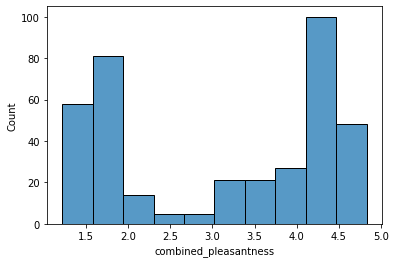

In [255]:
sns.histplot(bellezza_test_merge['combined_pleasantness'])

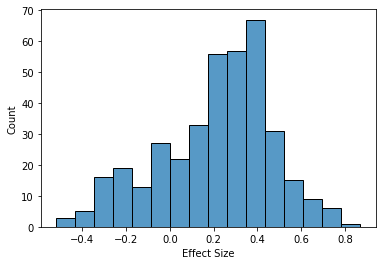

In [254]:
sns.histplot(bellezza_test_merge['Effect Size'])

In [1]:
bellezza_test_merge

NameError: name 'bellezza_test_merge' is not defined